# Installation of libraries Required for this Code

In [1]:
!pip install networkx
!pip install geopy
!pip install basemap
!pip install folium
!pip install pandas
!pip install matplotlib
!pip install IPython

In [2]:
import pandas as pd
from IPython.display import Image

#After downloading the Dataset.csv file, add the path here
data_path_new = 'Dataset.csv'
capitals_full_df = pd.read_csv(data_path_new)

# Creating Graph From Raw Dataset
Having a raw dataset e.g capital countrues datatset, just consists of capital cities names, longitutdes and latitudes. To implement any search algorithm, such dataset needs to be converted in a graph having nodes and edges. Below function add_edges serves this purpose and adds edges between nodes if they are within a specified distance threshold. The function makes each capital country as node and takes each pair of nodes, calculates the geodesic distance between them using their latitude and longitude, and adds an edge if this distance is less than threshold_km. 

In [3]:
import networkx as nx
from geopy.distance import geodesic

G = nx.Graph()

for index, row in capitals_full_df.iterrows():
    G.add_node(row['Capital City'], country=row['Country'], latitude=row['Latitude'], longitude=row['Longitude'])

def add_edges(graph, threshold_km=3000):
    nodes = list(graph.nodes(data=True))
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            node1 = nodes[i]
            node2 = nodes[j]
            coord1 = (node1[1]['latitude'], node1[1]['longitude'])
            coord2 = (node2[1]['latitude'], node2[1]['longitude'])
            distance = geodesic(coord1, coord2).kilometers
            if distance < threshold_km:
                graph.add_edge(node1[0], node2[0], weight=distance)

add_edges(G, threshold_km=4000)

G.number_of_nodes(), G.number_of_edges()

(234, 5593)

# Visualizing the Graph on Globe

`mpl_toolkits.basemap` (Basemap): A toolkit in Matplotlib that assists in drawing geographical maps.

This process may takes some time

c:\Users\arlml\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


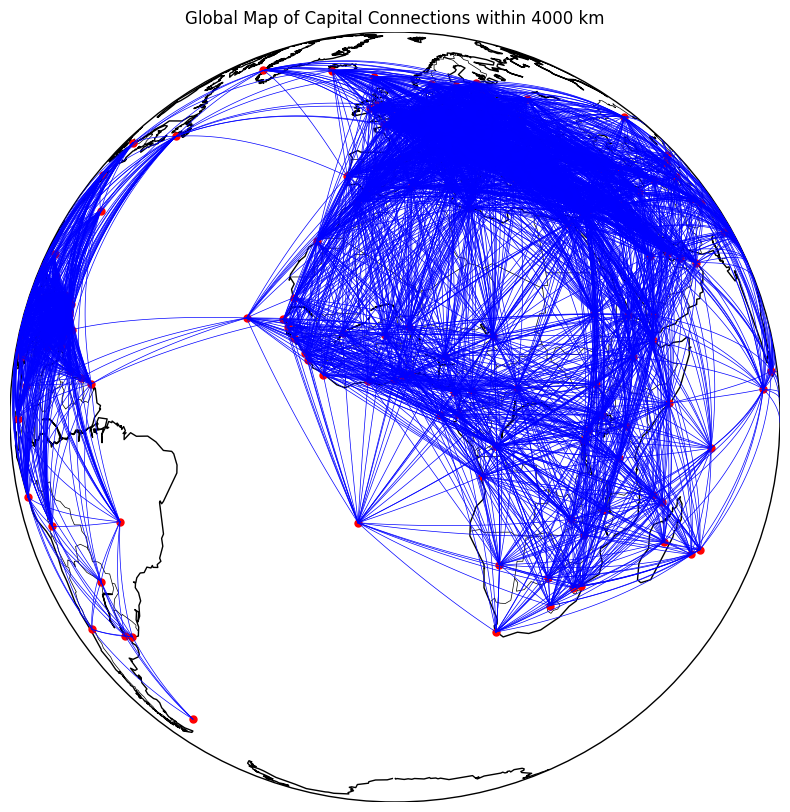

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(14, 10))
m = Basemap(projection='ortho', lat_0=0, lon_0=0)

# Draw coastlines and countries for context
m.drawcoastlines()
m.drawcountries()
#Draw Nodes
for node, data in G.nodes(data=True):
    x, y = m(data['longitude'], data['latitude'])
    m.plot(x, y, marker='o', color='red', markersize=5)

# Draw Edges
for u, v in G.edges():
    lat1, lon1 = G.nodes[u]['latitude'], G.nodes[u]['longitude']
    lat2, lon2 = G.nodes[v]['latitude'], G.nodes[v]['longitude']
    x1, y1 = m(lon1, lat1)
    x2, y2 = m(lon2, lat2)
    
    try:
        
        m.drawgreatcircle(lon1, lat1, lon2, lat2, linewidth=0.5, color='blue')
    except:
       
        continue

plt.title('Global Map of Capital Connections within 4000 km')
plt.show()

# Implementation of Bidirectional Search Algorithm

You need to fill out below `bidirectional_best_first_search` part.

Use pseudocode on lecture pdf or book.

For convenience, pseudocode is attatched on assignment zip file and ipynb file.

You need to submit your ipynb and report files as `StudentID_HW2.ipynb`, `StudentID_HW2.pdf`.

Only `pdf` and `word` format is allowed for report.


<img src="BDBS.jpg" width="1030" height="947"/>

In [5]:
import heapq

def haversine(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

def bidirectional_best_first_search(graph, start, goal):
    
    # TODO: You need to finish Bidirectional Best First Search.
    # haversine function: returns distance between two coordinates in km. Use this if you need it.
    
    """ Bidirectional Best First Search """
    
    # Check if start and goal are directly connected
    if goal in graph[start]:
        return [start, goal], None, graph[start][goal]['weight']

    # Check if start and goal are the same
    if start == goal:
        return [start], None, 0

    def get_coords(G, node):
        # Get the coordinates of a node from the graph
        return (G.nodes[node]['latitude'], G.nodes[node]['longitude'])

    def reconstruct_path(start_reached, goal_reached, meeting):
        # Reconstruct the path from the start to the meeting point and from the goal to the meeting point
        path = []
        current_node = meeting
        path.append(current_node)
        while start_reached[current_node][1] != "root":
            path.insert(0, start_reached[current_node][1])
            current_node = start_reached[current_node][1]

        current_node = meeting
        while goal_reached[current_node][1] != "root":
            path.append(goal_reached[current_node][1])
            current_node = goal_reached[current_node][1]

        return path

    def calculate_path_cost(graph, solution):
        # Calculate the total cost of a path
        solution_cost = 0
        for i in range(1, len(solution)):
            solution_cost += haversine(get_coords(graph, solution[i-1]), get_coords(graph, solution[i]))
        return solution_cost

    # Initialize the data structures for the search
    forward_frontier = []
    heapq.heappush(forward_frontier, (haversine(get_coords(graph, start), get_coords(graph, goal)), start))
    forward_reached = {start: (0, "root")}
    
    backward_frontier = []
    heapq.heappush(backward_frontier, (haversine(get_coords(graph, goal), get_coords(graph, start)), goal))
    backward_reached = {goal: (0, "root")}
    
    meeting_point = None
    solution_cost = float('inf')
    solution = None

    # Perform the bidirectional search until meeting point is found
    while forward_reached[forward_frontier[0][1]][0] + backward_reached[backward_frontier[0][1]][0] < solution_cost:
        
        # Explore the nodes in the forward direction
        forward_node = heapq.heappop(forward_frontier)[1]
        
        for neighbor in graph[forward_node]:
            neighbor_cost = graph[forward_node][neighbor]['weight'] + forward_reached[forward_node][0]
            if neighbor not in forward_reached or neighbor_cost < forward_reached[neighbor][0]:
                forward_reached[neighbor] = (neighbor_cost, forward_node) 
                heapq.heappush(forward_frontier, (haversine(get_coords(graph, neighbor), get_coords(graph, goal)) + neighbor_cost, neighbor))
                if neighbor in backward_reached:
                    current_solution_cost = calculate_path_cost(graph, reconstruct_path(backward_reached, forward_reached, neighbor))
                    if current_solution_cost < solution_cost:
                        meeting_point = neighbor
                        solution = reconstruct_path(backward_reached, forward_reached, meeting_point)
                        solution_cost = current_solution_cost

        # Explore the nodes in the backward direction
        backward_node = heapq.heappop(backward_frontier)[1]
        
        for neighbor in graph[backward_node]:
            neighbor_cost = graph[backward_node][neighbor]['weight'] + backward_reached[backward_node][0]
            if neighbor not in backward_reached or neighbor_cost < backward_reached[neighbor][0]:
                backward_reached[neighbor] = (neighbor_cost, backward_node) 
                heapq.heappush(backward_frontier, (haversine(get_coords(graph, neighbor), get_coords(graph, start)) + neighbor_cost, neighbor))
                if neighbor in forward_reached:
                    current_solution_cost = calculate_path_cost(graph, reconstruct_path(backward_reached, forward_reached, neighbor))
                    if current_solution_cost < solution_cost:
                        meeting_point = neighbor
                        solution = reconstruct_path(backward_reached, forward_reached, meeting_point)
                        solution_cost = current_solution_cost

    # Find the meeting point between start and goal
    meeting_index = len(solution) // 2
    meeting_point = solution[meeting_index]

    # Reverse the solution
    solution = list(reversed(solution))
        
    # Return the solution, meeting point, and solution cost
    return solution, meeting_point, solution_cost
    
    # You need to return below value for visualization 
    # return solution, meeting_point, solution_cost if solution else (None, None, 0)

In [6]:
# Use this part to change starting point and end point
start_point = 'Seoul'
end_point = 'Dublin'

# start_point = 'Seoul'
# end_point = 'Seoul'

# start_point = 'Seoul'
# end_point = 'Tokyo'

# Call the bidirectional_best_first_search function
path, meeting_point, total_distance = bidirectional_best_first_search(G, start_point, end_point)

# Print the results
print(f"Shortest path using bidirectional best-first search: {path}")
print(f"Meeting point: {meeting_point}")
print(f"Total distance: {total_distance} km")

Shortest path using bidirectional best-first search: ['Seoul', 'Ulaanbaatar', 'Astana', 'Tallinn', 'Dublin']
Meeting point: Astana
Total distance: 9604.545075965807 km


In [7]:
import folium

def visualize_bidirectional_paths(graph, start_city, end_city):
    path, meeting_point, total_distance = bidirectional_best_first_search(graph, start_city, end_city)
    
    if path is None:
        print("No path found between the cities.")
        return None

    # Initialize the map centered on the start city
    start_coords = (graph.nodes[start_city]['latitude'], graph.nodes[start_city]['longitude'])
    map = folium.Map(location=start_coords, zoom_start=4, tiles='CartoDB positron')
    
    if len(path) == 1:  # Start and end cities are the same
        city_coords = (graph.nodes[start_city]['latitude'], graph.nodes[start_city]['longitude'])
        folium.Marker(city_coords, popup=f"{start_city} (Coords: {city_coords[0]:.2f}, {city_coords[1]:.2f})", icon=folium.Icon(color='blue')).add_to(map)
        return map 

    if len(path) == 2:  # Direct connection without meeting point
        start_city_coords = (graph.nodes[start_city]['latitude'], graph.nodes[start_city]['longitude'])
        end_city_coords = (graph.nodes[end_city]['latitude'], graph.nodes[end_city]['longitude'])
        folium.Marker(start_city_coords, popup=f"{start_city} (Coords: {start_city_coords[0]:.2f}, {start_city_coords[1]:.2f})", icon=folium.Icon(color='blue')).add_to(map)
        folium.Marker(end_city_coords, popup=f"{end_city} (Coords: {end_city_coords[0]:.2f}, {end_city_coords[1]:.2f})", icon=folium.Icon(color='blue')).add_to(map)
        segment_distance = geodesic(start_city_coords, end_city_coords).kilometers
        distance_popup = folium.Popup(f"{segment_distance:.2f} km", parse_html=True)
        folium.PolyLine([start_city_coords, end_city_coords], color='blue', weight=3, popup=distance_popup).add_to(map)
        return map

    previous_city_coords = None
    for index, city in enumerate(path):
        city_coords = (graph.nodes[city]['latitude'], graph.nodes[city]['longitude'])
        if city == meeting_point:
            marker_color = 'green'  
            popup_text = f'Meeting Point: {city} (Total Path Distance: {total_distance:.2f} km)'
        else:
            marker_color = 'blue' if index < path.index(meeting_point) else 'red'
            popup_text = f"{city} (Coords: {city_coords[0]:.2f}, {city_coords[1]:.2f})"

        folium.Marker(city_coords, popup=popup_text, icon=folium.Icon(color=marker_color)).add_to(map)

        if previous_city_coords:
            segment_distance = geodesic(previous_city_coords, city_coords).kilometers
            distance_popup = folium.Popup(f"{segment_distance:.2f} km", parse_html=True)
            line_color = 'blue' if index <= path.index(meeting_point) else 'red'
            folium.PolyLine([previous_city_coords, city_coords], color=line_color, weight=3, popup=distance_popup).add_to(map)
        
        previous_city_coords = city_coords

    return map

map_result = visualize_bidirectional_paths(G, start_point, end_point)
if map_result:
    map_result.save(f'path_visualization_{start_point}_to_{end_point}.html')
    print(f"Map created successfully. Open 'path_visualization_{start_point}_to_{end_point}.html' to view it.")
else:
    print("Failed to create the map.")


visualize_bidirectional_paths(G, start_point, end_point)

Map created successfully. Open 'path_visualization_Seoul_to_Dublin.html' to view it.
